## Diplomski rad - Klasificiranje LEGO kocaka koristeći neuronske mreže

Rad se izvodi koristeći PlaidML za AMD GPU preko Keras-a

In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

Promijene vezane za PlaidML se mogu izvesti sa pokretanjem `plaidml-setup` u powershell-u

Sve sljedece linije ce se spominjati na Engleskom jeziku zbog jednostavnosti i istoznacnosti sa programskim ködom na engleskom jeziku

In [2]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import cv2

Using plaidml.keras.backend backend.


Now let's explore some of the data, for starters we will use the following Kaggle dataset: [lego-brick-images](https://www.kaggle.com/joosthazelzet/lego-brick-images)

It's a fairly simple dataset containing renders of some LEGO pieces

In [3]:
os.listdir("../../LEGO_brick_custom")

['18575 Double Conical Wheel Z20 1M',
 '2340 Rudder 1x4x3',
 '2357 Brick corner 1x2x2',
 '2420 plate corner 2x2',
 '3001 brick 2x4',
 '3003 Brick 2x2',
 '3004 Brick 1x2',
 '3005 Brick 1x1',
 '3010 brick 1x4',
 '3020 plate 2x4',
 '3022 Plate 2x2',
 '3023 Plate 1x2',
 '3024 Plate 1x1',
 '3037 roof tile 2x4',
 '3040 Roof Tile 1x2x45deg',
 '32140 Technic Ang Beam 4x2 90Deg',
 '3298 roof tile 2x3',
 '4083 Hanger 1x4x2',
 '41678 Cross Block Fork 2x2',
 '4276 Worm',
 '4286 roof tile 1x3',
 '4864 Wall Element 1x2x2',
 '6143 Brick D16 w cross',
 '6632 lever 3M',
 '99301 roof tile inside 3x3']

In [4]:
len(os.listdir("../../LEGO_brick_custom"))

25

The first numbers denote the brick model, after that is it's name, size and possible modifications

In [5]:
os.listdir("../../LEGO_brick_custom/3003 Brick 2x2/")[:10]

['test_0_0.png',
 'test_0_1.png',
 'test_0_10.png',
 'test_0_11.png',
 'test_0_12.png',
 'test_0_13.png',
 'test_0_14.png',
 'test_0_15.png',
 'test_0_16.png',
 'test_0_17.png']

We can see that the folder are filled with individual .png files, these are loadable in Keras.

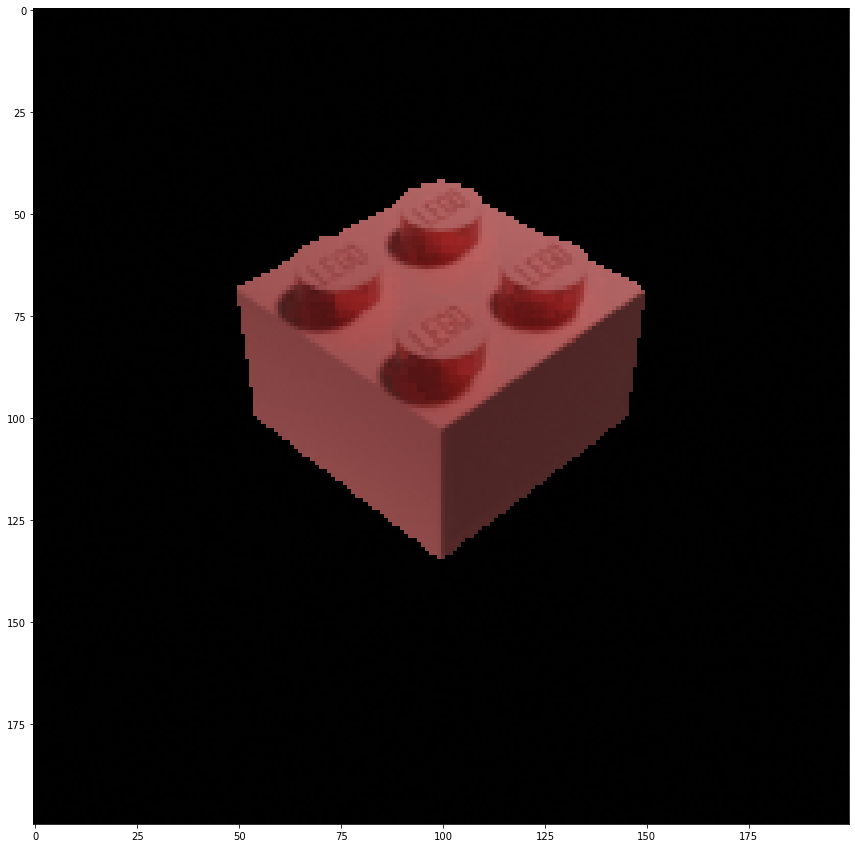

In [5]:
image_path = "../../LEGO_brick_custom/3003 Brick 2x2/test_6_40.png"
image = cv2.imread(image_path)
plt.figure(figsize=(15,15))
plt.imshow(image)

In [7]:
image.shape

(200, 200, 3)

To try to load the data into Keras, we must first create a subset for training and validation

In [6]:
dataset_path = "../../LEGO_brick_custom/"
dataset_output = "./output"

In [9]:
#if you want you can run this once, but some randomness can be good
import splitfolders
splitfolders.ratio(dataset_path, output=dataset_output, ratio=(.7, .3))

os.listdir(dataset_output)

KeyboardInterrupt: 

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=10,
    zoom_range=[1,1.2],
    height_shift_range=0.2,
    width_shift_range=0.2,
    brightness_range=[0.6,1],
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True
)
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(os.path.join(dataset_output,'train'), color_mode="rgba", target_size=(200,200), shuffle=True, class_mode="categorical")
validation_generator = validation_datagen.flow_from_directory(os.path.join(dataset_output, 'val'), color_mode="rgba", target_size=(200,200), shuffle=True, class_mode='categorical')


print(len(train_generator.class_indices))

C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Anto\anaconda3\envs\lego_

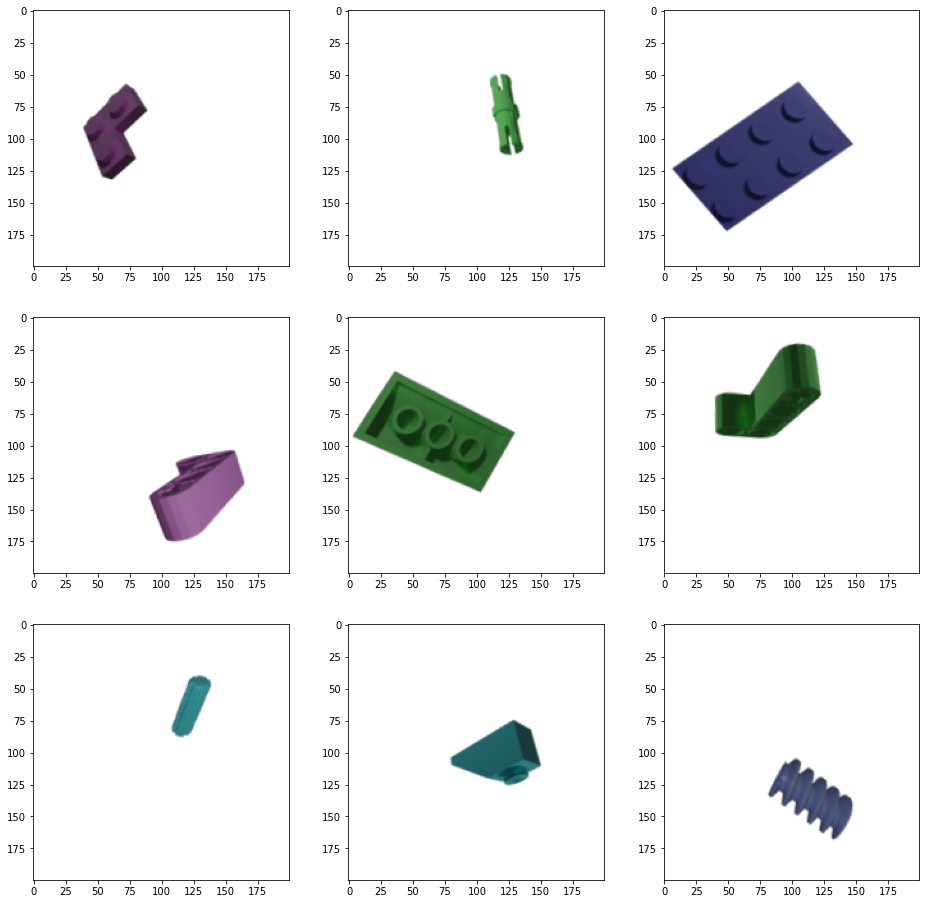

In [11]:
plt.figure(figsize=(16,16))
for i in range(9):
    plt.subplot(330+1+i)
    batch = train_generator.next()[0]
    plt.imshow(batch[0])
plt.show()


Now to declare a model and modify it, we can also use preexisting ones like VGG16 or ResNet but for this test we are using a simple one

In [8]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential, Model

model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(200,200,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(train_generator.class_indices), activation="softmax"))

model.summary()

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 313632)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                20072512  
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 27)                1755      
Total params: 20,075,163
Trainable params: 20,075,163
Non-trainable params: 0
___________

In [10]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file="model/model_vertical.png", show_shapes = True)
plot_model(model, to_file="model/model_horizontal.png", show_shapes = True)

In [14]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau

best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)


reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce,earlystop]

C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\keras\callbacks.py:756: UserWarning: You are not using the TensorFlow backend. write_graph was set to False
  warnings.warn('You are not using the TensorFlow backend. '


In [16]:
from keras.optimizers import SGD

opt = SGD(lr=1e-2) #dobar za plitke mreže
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

history = model.fit_generator(
    train_generator, 
    steps_per_epoch  = 100, 
    validation_data  = validation_generator,
    validation_steps = 100,
    epochs = 100, 
    verbose = 1,
    callbacks=callbacks
)

json_model = model.to_json()

with open("./model/lego.json", "w") as json_file:
    json_file.write(json_model)

model.save_weights("./model/lego_weights.h5")

Epoch 1/100
100/100 [==============================] - 152s 2s/step - loss: 3.2411 - acc: 0.0553 - val_loss: 3.1299 - val_acc: 0.0663

Epoch 00001: val_loss improved from inf to 3.12992, saving model to ./base.model
Epoch 2/100
100/100 [==============================] - 139s 1s/step - loss: 3.1897 - acc: 0.0722 - val_loss: 3.0743 - val_acc: 0.0841

Epoch 00002: val_loss improved from 3.12992 to 3.07429, saving model to ./base.model
Epoch 3/100
100/100 [==============================] - 139s 1s/step - loss: 3.1569 - acc: 0.0659 - val_loss: 3.0189 - val_acc: 0.0925

Epoch 00003: val_loss improved from 3.07429 to 3.01890, saving model to ./base.model
Epoch 4/100
100/100 [==============================] - 143s 1s/step - loss: 3.1233 - acc: 0.0675 - val_loss: 2.9665 - val_acc: 0.1125

Epoch 00004: val_loss improved from 3.01890 to 2.96654, saving model to ./base.model
Epoch 5/100
100/100 [==============================] - 115s 1s/step - loss: 3.0673 - acc: 0.0809 - val_loss: 2.9216 - val_ac

In [17]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

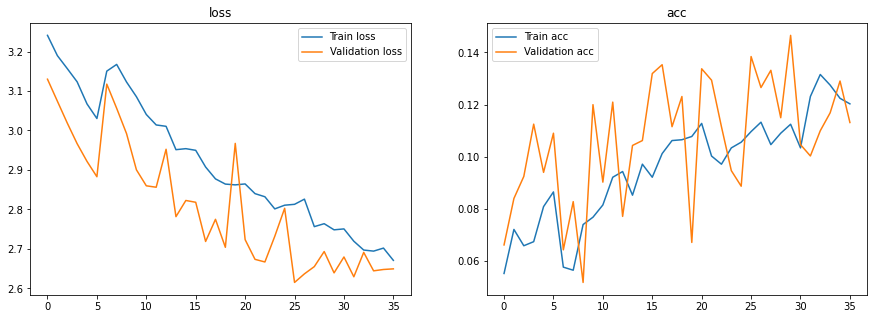

In [18]:
show_final_history(history)